<a href="https://colab.research.google.com/github/iCarrrot/nn_sudoku_project/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End of term project for Deep Learning course, SS 2020 @ University of Wrocław
Authors:
* Piotr Gdowski
* Michał Martusewicz


## Main goal
Extend the handwritten digit-recognizing network to allow verifying sudoku's solution correctness

# Befor start: runtime -> change runtime type -> GPU

In [2]:
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

from sklearn.neighbors import KNeighborsClassifier
import torch
import torchvision
from sklearn.decomposition import PCA


try:
    from src.net import *
    from src.preprocessing import *
    from src.util import *
    
except ModuleNotFoundError:
    import httpimport
    with httpimport.github_repo(
            'iCarrrot', 
            'nn_sudoku_project',
            module='src',
            branch='master'
    ):
        from src.net import *
        from src.preprocessing import *
        from src.util import *

from collections import namedtuple
GridInstance = namedtuple('GridInstace', 'img digits')

Populating the interactive namespace from numpy and matplotlib


TODO

* dopisać metodę sprawdzającą czy kratka jest pusta
* improvement modelu

In [3]:
pics_path = get_pics_path()
gray_images, labels = get_gray_images(pics_path)
gray_images.shape

(101, 4160, 3120)

# Dataset

We've collected and labeled a dataset consisting of 101 sudoku grids, which we splitted into three parts after preprocessing:
* 10 grids will be our test dataset on which we'll show how the full checker works
* ca. 5000 digits will be put to the model as a training data
* the rest will serve as verification dataset

100%|██████████| 101/101 [01:42<00:00,  1.02s/it]


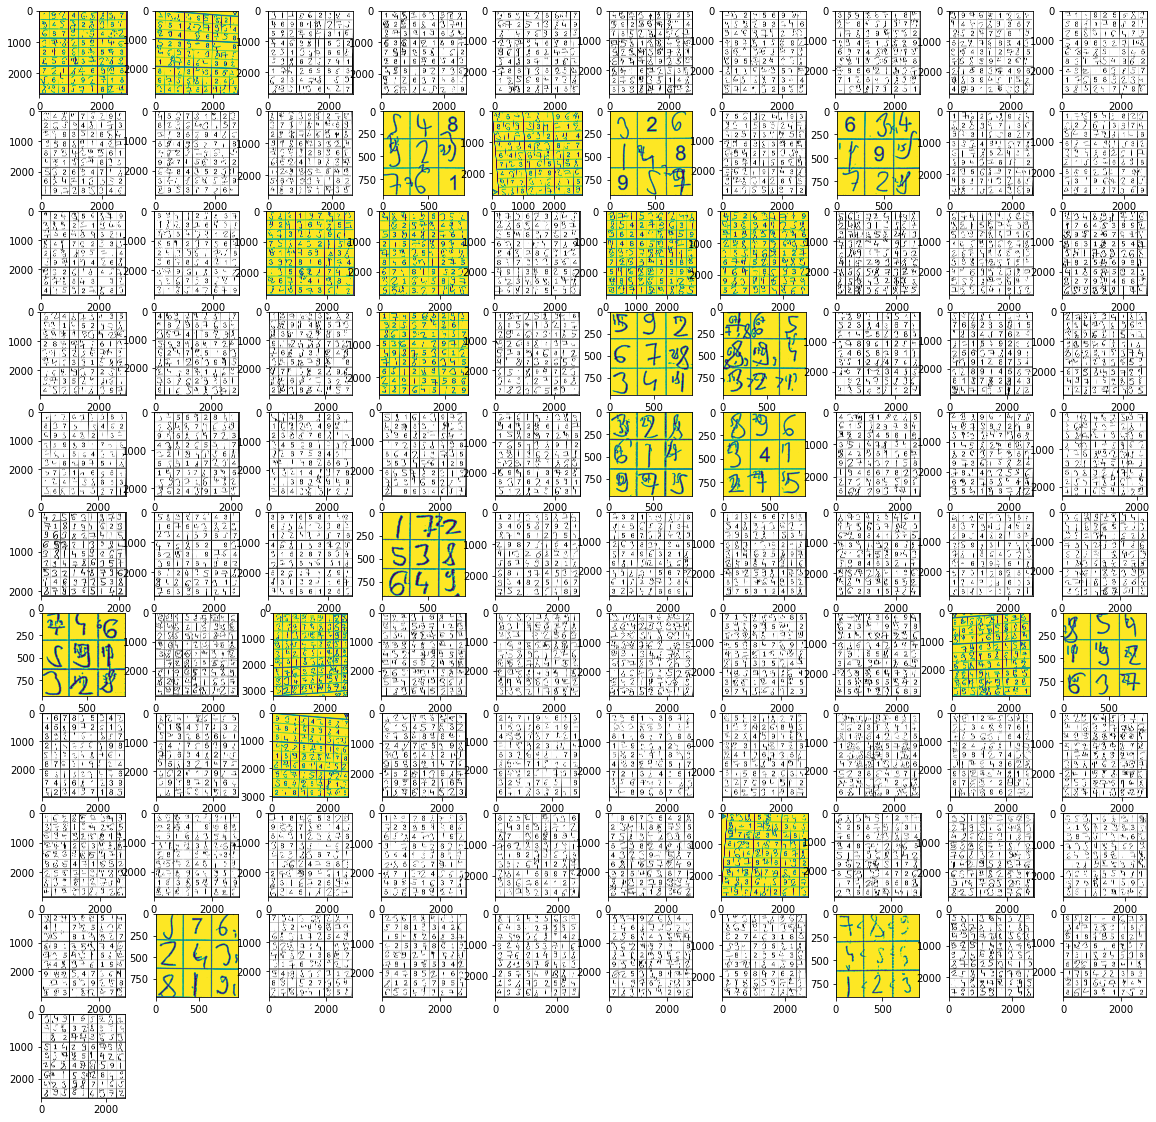

In [4]:
deskewed_imgs = []
desk_img_labels = []
plt.figure(figsize=(20, 20))
for i in tqdm(range(len(gray_images))):
    deskewed = Deskewing(gray_images[i])._deskew()
    plt.subplot(11, 10, i + 1)
    if i == 1 or not deskew_verify(deskewed):
        plt.imshow(deskewed)
    else:
        plt.imshow(deskewed, cmap='gray')
        deskewed_imgs.append(deskewed)
        desk_img_labels.append(labels[i])

In [ ]:
errors = []
for idx, (img, y) in enumerate(zip(deskewed_imgs, desk_img_labels)):
    if sum(y) != 9 * 45:
        errors.append(idx)
        # print(idx, np.asarray(y).reshape(9,9))
    plt.imshow(img, cmap='gray')
    plt.title(f"{idx}, {sum(y)}")
    plt.show()

## Dataset split

In [30]:
testset_ids = np.array([9,12,13,22,24,27,32,35,37,50])

testset, trainset = [], []
for i in range(len(desk_img_labels)):
    if i in testset_ids:
        testset.append(GridInstance(img=deskewed_imgs[i], digits=np.asarray(desk_img_labels[i])))
    else:
        trainset.append(GridInstance(img=deskewed_imgs[i], digits=np.asarray(desk_img_labels[i])))

print(sorted(testset_ids))

[9, 12, 13, 22, 24, 27, 32, 35, 37, 50]


In [6]:
digits_labels = np.hstack([g.digits for g in trainset])
digits = np.vstack([split_into_cells(g.img) for g in trainset])
digits.shape

(5427, 28, 28)

In [9]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('files/', train=True, download=True,
        transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])), 
    batch_size=batch_size_train, 
    shuffle=True)

grid_test_loader, grid_train_loader = get_test_and_train_dataloader(
    digits, 
    digits_labels, 
    batch_size_test = batch_size_test, 
    device='cuda')

## MNIST Dataset - sample digits and T-SNE decomposition




0it [00:00, ?it/s]


10it [00:00, 98.01it/s]


21it [00:00, 99.09it/s]


31it [00:00, 98.52it/s]


41it [00:00, 97.90it/s]


51it [00:00, 98.32it/s]


61it [00:00, 97.99it/s]


71it [00:00, 95.75it/s]


81it [00:00, 95.70it/s]


91it [00:00, 96.31it/s]


102it [00:01, 98.46it/s]


112it [00:01, 97.63it/s]


122it [00:01, 98.01it/s]


132it [00:01, 97.47it/s]


142it [00:01, 96.40it/s]


153it [00:01, 98.61it/s]


164it [00:01, 100.36it/s]


175it [00:01, 96.80it/s] 


185it [00:01, 96.26it/s]


195it [00:02, 95.69it/s]


205it [00:02, 96.55it/s]


216it [00:02, 97.96it/s]


226it [00:02, 95.34it/s]


237it [00:02, 97.69it/s]


247it [00:02, 95.71it/s]


258it [00:02, 97.90it/s]


268it [00:02, 98.27it/s]


278it [00:02, 96.57it/s]


288it [00:02, 97.02it/s]


299it [00:03, 99.69it/s]


310it [00:03, 100.77it/s]


321it [00:03, 100.58it/s]


332it [00:03, 101.59it/s]


343it [00:03, 99.41it/s] 


354it [00:03, 100.89it/s]


365it [00:03, 101.43it/s]


376it [00:03, 100.02it/s]


387i

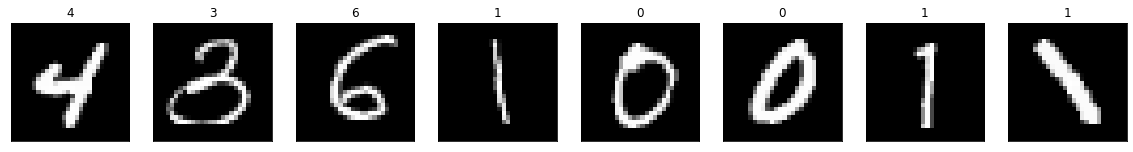

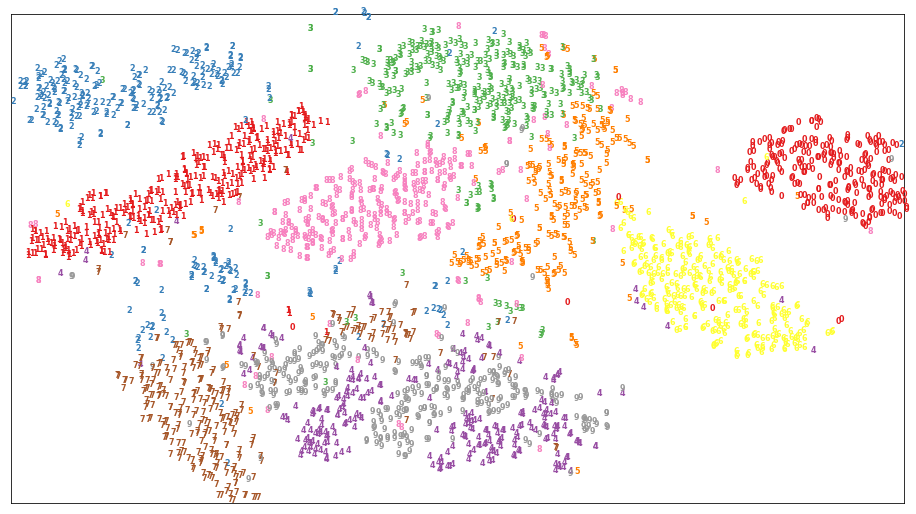

In [314]:
present_dataset(train_loader)

## Digits from sudoku grids - sample digits and T-SNE decomposition




119it [00:00, 1648.67it/s]


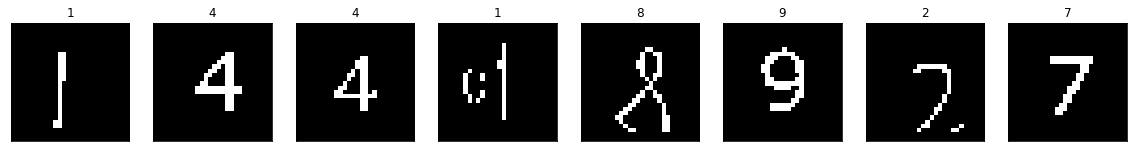

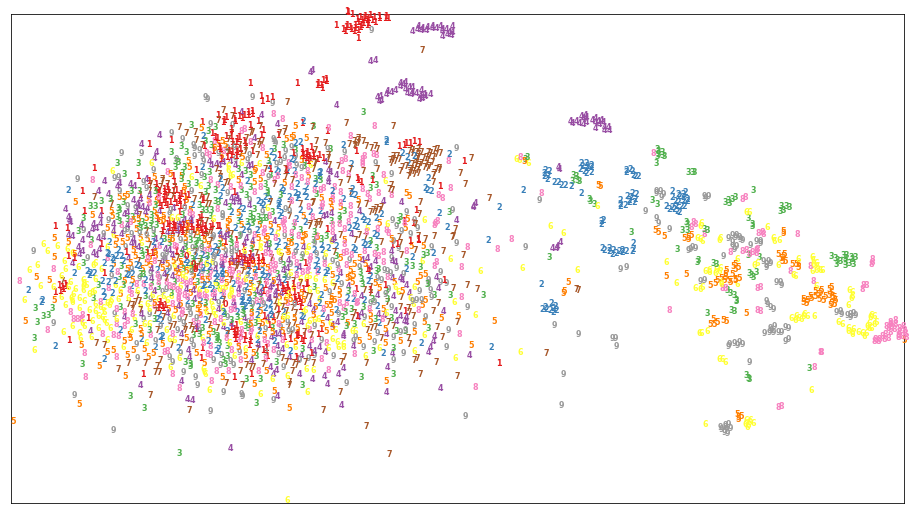

In [315]:
present_dataset(grid_train_loader)

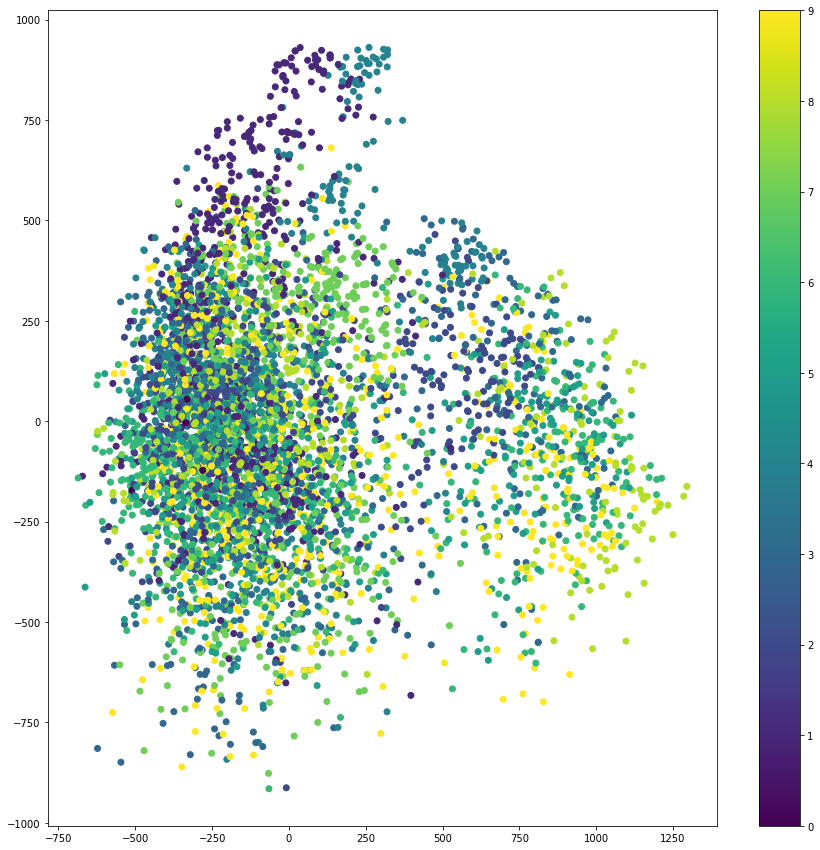

In [316]:
pca = PCA(n_components=2)
X = pca.fit_transform(digits.reshape(-1, 28*28))
X.shape
plt.figure(figsize=(15,15))
plt.scatter(X[:,0], X[:,1], c=digits_labels)
plt.colorbar()

# Classification

In this section we'll compare several approaches on classifying sudoku grids' digits.

## KNN

### 1: train on MNIST, test on sudoku_test

In [ ]:
X, y = get_pure_data(train_loader)
clf = KNeighborsClassifier()
clf.fit(X, y)

X_test, y_test = get_pure_data(grid_test_loader)

clf.score(X_test, y_test)

0.248388696083292

### 2: train on sudoku_train, test on sudoku_test

In [ ]:
X, y = get_pure_data(grid_train_loader)
clf = KNeighborsClassifier()
clf.fit(X, y)

X_test, y_test = get_pure_data(grid_test_loader)

clf.score(X_test, y_test)

0.46554288547347544

### 3: train on PCA(sudoku_train), test on PCA(sudoku_test)

In [ ]:
X, y = get_pure_data(grid_train_loader)
X_test, y_test = get_pure_data(grid_test_loader)

for n_components in [10, 20, 30, 35, 40, 45, 50, 70, 100, 200]:
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    pca_train = pca.transform(X)
    pca_test = pca.transform(X_test)
    
    clf = KNeighborsClassifier()
    clf.fit(pca_train, y)

    print(f"{n_components} components: {clf.score(pca_test, y_test)}")


10 components: 0.6450173525037184
20 components: 0.7248388696083292
30 components: 0.7327714427367378
39 components: 0.7263262270699058
40 components: 0.7377293009419931
41 components: 0.7317798710956867
42 components: 0.7327714427367378
45 components: 0.7273177987109569
50 components: 0.7268220128904314
70 components: 0.7045116509667824
100 components: 0.6608824987605354
200 components: 0.5547843331680714


## NN

### Approach 1: Simple NN on different datasets

In [ ]:
model = Net()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train Epoch: Train on mnist dataset [0/60000 (0%)]	Loss: 2.309647
Train Epoch: Train on mnist dataset [6400/60000 (11%)]	Loss: 0.200662
Train Epoch: Train on mnist dataset [12800/60000 (21%)]	Loss: 0.067301
Train Epoch: Train on mnist dataset [19200/60000 (32%)]	Loss: 0.264715
Train Epoch: Train on mnist dataset [25600/60000 (43%)]	Loss: 0.068207
Train Epoch: Train on mnist dataset [32000/60000 (53%)]	Loss: 0.132696
Train Epoch: Train on mnist dataset [38400/60000 (64%)]	Loss: 0.083295
Train Epoch: Train on mnist dataset [44800/60000 (75%)]	Loss: 0.069763
Train Epoch: Train on mnist dataset [51200/60000 (85%)]	Loss: 0.152600
Train Epoch: Train on mnist dataset [57600/60000 (96%)]	Loss: 0.074948

Test set: Average loss: 125.8736, Accuracy: 1133/2017 (56%)



In [29]:
model = Net()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on own dataset
Train, Epoch: 1/1 [0/3726 (0%)]	Loss: 12.501904
Train, Epoch: 1/1 [3200/3726 (85%)]	Loss: 1.556952

Test set: Average loss: 0.8842, Accuracy: 1258/1701 (74%)



In [35]:
class FinalNet(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(1, 32, 3, 1)
       self.conv2 = nn.Conv2d(32, 64, 5, 1)
       self.conv3 = nn.Conv2d(64, 128, 5, 1)
       self.conv4 = nn.Conv2d(128, 512, 9, 1)
       self.dropout1 = nn.Dropout2d(0.25)
       self.dropout2 = nn.Dropout2d(0.5)
       self.fc1 = nn.Linear(12800, 128)
       self.fc2 = nn.Linear(128, 10)

   def forward(self, x):
       x = self.conv1(x)
       x = F.relu(x)
       x = self.conv2(x)
       x = F.relu(x)
       x = self.conv3(x)
       x = F.relu(x)
       x = self.conv4(x)
       x = F.relu(x)
       x = F.max_pool2d(x, 2)
       x = self.dropout1(x)
       x = torch.flatten(x, 1)
       x = self.fc1(x)
       x = F.relu(x)
       x = self.dropout2(x)

       x = self.fc2(x)
       output = F.log_softmax(x, dim=1)
       return output

### Approach 2: Simple NN on different datasets

In [ ]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, epoch=15, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

In [32]:
model = FinalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=15, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on own dataset


AttributeError: ignored

## Saving model

In [11]:
torch.save(model.state_dict(), '/random_net.xyz')

In [12]:
restored_model = ExperimentalNet()
restored_model.load_state_dict(torch.load('/random_net.xyz'))

<All keys matched successfully>

In [13]:
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)


Test set: Average loss: 0.4903, Accuracy: 1515/1701 (89%)



### Reload final net

In [37]:
restored_model = FinalNet()
restored_model.load_state_dict(torch.load('drive/My Drive/dataset/sudoku_net.nn'))
restored_model.cuda()
prediction = test(model=restored_model, device='cuda', test_loader=grid_test_loader)


Test set: Average loss: 0.4561, Accuracy: 1591/1701 (94%)



# Real life application

Given a sudoku grid, find errors or say it's fine

In [44]:
def get_predictions(model, device, dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

    return pred.cpu().numpy().reshape((9,9)), output.cpu().numpy()

img, y = testset[4]
grid_cells = split_into_cells(img)
nonempty_cells = []
for idx, cell in enumerate(grid_cells):
    # if detect_empty_cell(cell):
    #     pass
    #     # mark on grid
    # else:
    nonempty_cells.append(idx)

grid_dataloader = get_dataloader(grid_cells[nonempty_cells], y[nonempty_cells])

predicted, ppbs = get_predictions(restored_model, 'cuda', grid_dataloader)

In [56]:
def find_errors(grid, i, j):
    related = []
    for k in range(9):
        if grid[i, j] == grid[i, k] and j < k:
            related.append([(i, k), (i, j)])

        if grid[i, j] == grid[k, j] and i < k:
            related.append([(k, j), (i, j)])

    for k, l in itertools.product(range(3), range(3)):
        ci, cj = 3 * (i // 3) + k, 3 * (j // 3) + l
        if grid[i, j] == grid[ci, cj] and (ci > i or (cj > j and ci == i)) and [(ci, cj), (i, j)] not in related:
            related.append([(ci, cj), (i, j)])

    return related

def process_grid(grid_cells, y, model, threshold=0.95):    
    grid_dataloader = get_dataloader(grid_cells, y)
    predicted, ppbs = get_predictions(model, 'cuda', grid_dataloader)
    alternative_values = ppbs.argsort(axis=1)[:, -2].reshape((9,9))

    ppbs = np.e ** (ppbs)
    # print(predicted)
    associated_cells = []
    for i, j in itertools.product(range(9), range(9)):
        for cells in find_errors(predicted, i, j):
            associated_cells.append(cells)
            
    if len(associated_cells) == 0:
        return []
    
    error_chances = []
    cell_counts = {}
    for (i1, j1), (i2, j2) in associated_cells:
        if (i1, j1) not in cell_counts:
            cell_counts[(i1, j1)] = 0
        if (i2, j2) not in cell_counts:
            cell_counts[(i2, j2)] = 0

        cell_counts[(i1, j1)] += 1
        cell_counts[(i2, j2)] += 1
        predicted_digit = predicted[i1, j1]
        error_chances.append([ppbs[9 * i1 + j1, predicted_digit], ppbs[9 * i2 + j2, predicted_digit]])



    constraints_cover = np.zeros(len(cell_counts))
    for k in cell_counts:
        i,j = k
        # print(k, cell_counts[k], ppbs[9 * i + j, predicted[i, j]], ppbs[9 * i + j, alternative_values[i, j]], alternative_values[i, j])
    error_chances = np.asarray(error_chances)
    order = error_chances.mean(axis=1).argsort()[::-1]


    i = 1
    response = {'m': []}
    for index in order:
        if error_chances[index, :].mean() < threshold:
            break
        
        print(associated_cells[index], error_chances[index, :])
        
        if i == 1:
            response['o'] = associated_cells[index]
        else:
            response['m'].append(associated_cells[index])
        i += 1
    return response


def mark_error(img, errors, color=None, thick=50):
    cell_width = img.shape[0] // 9
    if color is None:
        color = (np.random.choice(255), np.random.choice(255), np.random.choice(255))

    for j, i in errors:
        img = cv2.rectangle(img, 
                        (i * cell_width, j * cell_width), 
                        ((i+1) * cell_width, (j+1) * cell_width),
                        color,
                        thick)
        
    return img

def check(instance, model, threshold):
    img, y = instance
    grid_cells = split_into_cells(img)

    empties = [( i // 9, i % 9) for i in range(81) if grid_cells[i].mean() > 252]

    if len(empties) > 0:
        error_dict = {'e' : empties}

    else:
        error_dict = process_grid(grid_cells, y, model, threshold=threshold)

    rgb_img = cv2.cvtColor(img ,cv2.COLOR_GRAY2RGB)

    if len(error_dict) > 0:
        for error_type, cells in error_dict.items():
            if error_type == 'e':
                final_img = mark_error(rgb_img, cells, color=(0, 0, 255))

            if error_type == 'o':
                final_img = mark_error(rgb_img, cells, color=(255, 0, 0))

            if error_type == 'm':
                for c in cells:
                    rgb_img = mark_error(rgb_img, c, thick=40)

    final_img = rgb_img


    plt.figure(figsize=(12 ,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.imshow(final_img)
    plt.show()
    
    if len(error_dict) == 0:
        # plt.imshow(rgb_img)
        # plt.show()
        print('This grid has no errors!')
        return


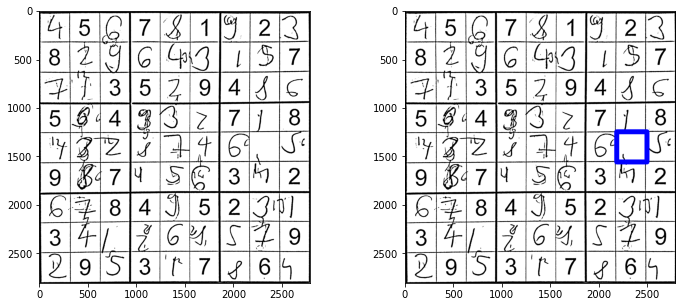

[(5, 8), (4, 8)] [1. 1.]
[(4, 8), (4, 5)] [1. 1.]


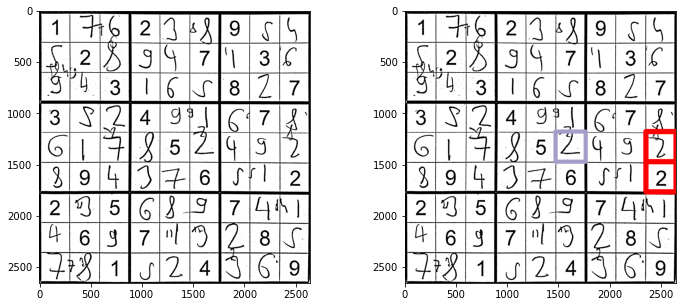

[(5, 8), (5, 6)] [1. 1.]
[(5, 6), (0, 6)] [1. 1.]


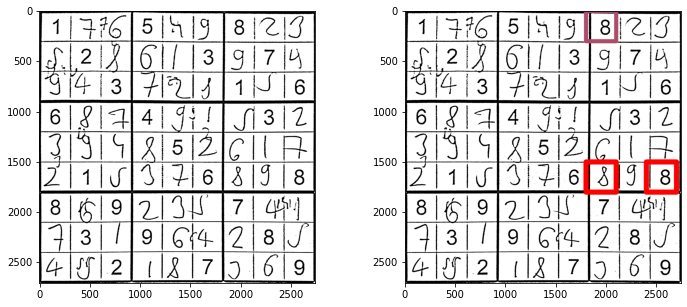

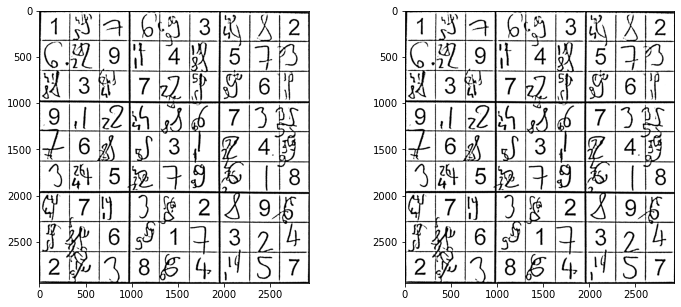

This grid has no errors!
[(5, 8), (5, 4)] [1. 1.]
[(5, 4), (4, 4)] [1. 1.]


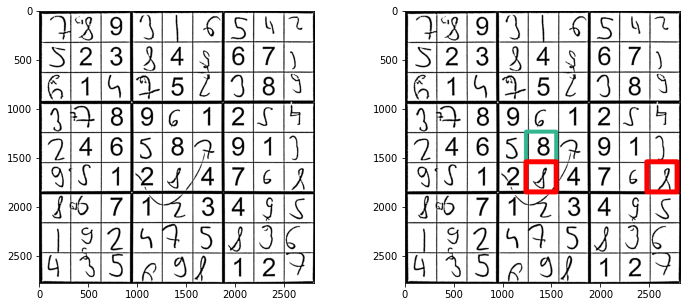

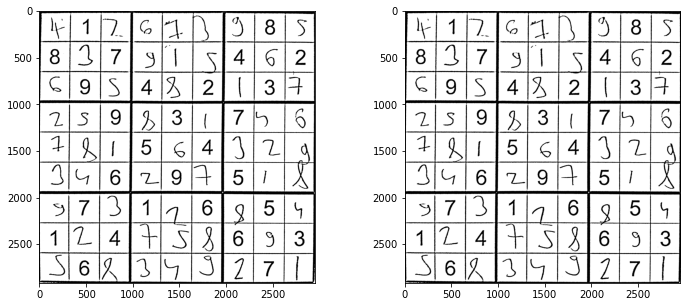

This grid has no errors!
[(5, 1), (4, 2)] [1. 1.]
[(5, 5), (5, 1)] [1. 1.]
[(4, 2), (2, 2)] [1. 1.]
[(6, 5), (1, 5)] [1.        0.9848087]
[(1, 6), (1, 5)] [1.        0.9848087]
[(2, 5), (1, 3)] [1.         0.97451025]
[(1, 3), (1, 2)] [0.97451025 1.        ]
[(6, 3), (1, 3)] [1.         0.97451025]
[(5, 4), (4, 5)] [1.        0.9520851]
[(8, 5), (4, 5)] [1.        0.9520851]
[(4, 6), (4, 5)] [0.9999962 0.9520851]
[(4, 3), (0, 3)] [1.         0.95088005]
[(0, 3), (0, 2)] [0.95088005 0.9998112 ]


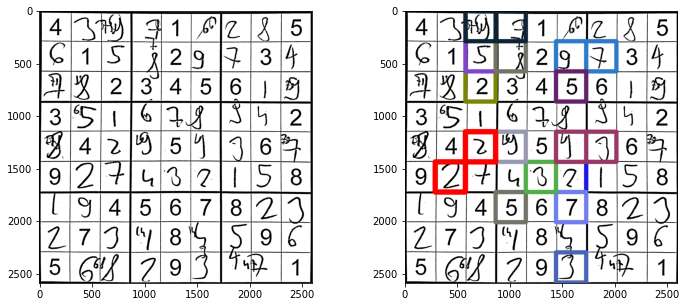

[(5, 0), (0, 0)] [1. 1.]
[(7, 1), (0, 1)] [1.         0.99998665]


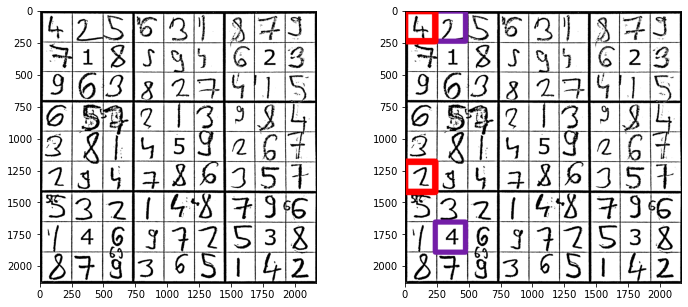

[(1, 4), (1, 3)] [1.         0.99989986]
[(3, 3), (1, 3)] [1.         0.99989986]


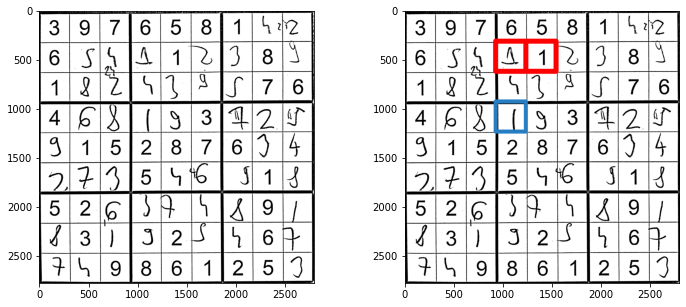

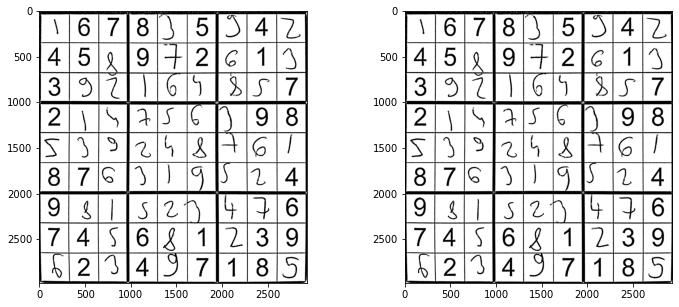

This grid has no errors!


In [57]:
# check(testset[1], restored_model, 0.95)
for gi in testset:
    check(gi, restored_model, 0.95)

# Not my sandbox
[PyTorch MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [ ]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=30, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))

prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on own dataset
Train, Epoch: 1/30 [0/4706 (0%)]	Loss: 10.714441
Train, Epoch: 2/30 [0/4706 (0%)]	Loss: 0.905210
Train, Epoch: 3/30 [0/4706 (0%)]	Loss: 0.709045
Train, Epoch: 4/30 [0/4706 (0%)]	Loss: 0.486021
Train, Epoch: 5/30 [0/4706 (0%)]	Loss: 0.307792
Train, Epoch: 6/30 [0/4706 (0%)]	Loss: 0.316494
Train, Epoch: 7/30 [0/4706 (0%)]	Loss: 0.238652
Train, Epoch: 8/30 [0/4706 (0%)]	Loss: 0.269505
Train, Epoch: 9/30 [0/4706 (0%)]	Loss: 0.211743
Train, Epoch: 10/30 [0/4706 (0%)]	Loss: 0.360622
Train, Epoch: 11/30 [0/4706 (0%)]	Loss: 0.142705
Train, Epoch: 12/30 [0/4706 (0%)]	Loss: 0.177260
Train, Epoch: 13/30 [0/4706 (0%)]	Loss: 0.113893
Train, Epoch: 14/30 [0/4706 (0%)]	Loss: 0.203387
Train, Epoch: 15/30 [0/4706 (0%)]	Loss: 0.234682
Train, Epoch: 16/30 [0/4706 (0%)]	Loss: 0.245698
Train, Epoch: 17/30 [0/4706 (0%)]	Loss: 0.094775
Train, Epoch: 18/30 [0/4706 (0%)]	Loss: 0.142434
Train, Epoch: 19/30 [0/4706 (0%)]	Loss: 0.128934
Train, Epoch: 20/30 [0/4706 (0%)]	Loss: 0.164129
Train, 

In [ ]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, epoch=1, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=23, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))

prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on mnist dataset
Train, Epoch: 1/1 [0/60000 (0%)]	Loss: 2.312994
Train, Epoch: 1/1 [6400/60000 (11%)]	Loss: 0.479052
Train, Epoch: 1/1 [12800/60000 (21%)]	Loss: 0.271688
Train, Epoch: 1/1 [19200/60000 (32%)]	Loss: 0.155875
Train, Epoch: 1/1 [25600/60000 (43%)]	Loss: 0.130625
Train, Epoch: 1/1 [32000/60000 (53%)]	Loss: 0.179897
Train, Epoch: 1/1 [38400/60000 (64%)]	Loss: 0.147403
Train, Epoch: 1/1 [44800/60000 (75%)]	Loss: 0.189315
Train, Epoch: 1/1 [51200/60000 (85%)]	Loss: 0.087876
Train, Epoch: 1/1 [57600/60000 (96%)]	Loss: 0.149057
Train on own dataset
Train, Epoch: 1/23 [0/4706 (0%)]	Loss: 141.777390
Train, Epoch: 2/23 [0/4706 (0%)]	Loss: 1.693252
Train, Epoch: 3/23 [0/4706 (0%)]	Loss: 1.324156
Train, Epoch: 4/23 [0/4706 (0%)]	Loss: 0.988420
Train, Epoch: 5/23 [0/4706 (0%)]	Loss: 1.407893
Train, Epoch: 6/23 [0/4706 (0%)]	Loss: 0.454623
Train, Epoch: 7/23 [0/4706 (0%)]	Loss: 0.623635
Train, Epoch: 8/23 [0/4706 (0%)]	Loss: 0.696565
Train, Epoch: 9/23 [0/4706 (0%)]	Loss: 0.56662